## Theory behind Ho et al's model

The code in this repository is an implementation of Algorithms 1 (Training) and 2 (Sampling) from [Ho et al 2020](https://arxiv.org/abs/2006.11239). The theory that leads to Algorithms 1 and 2 is beautifully presented in [Luo 2022](https://arxiv.org/abs/2208.11970). There are, however, a few places in Luo's exposition where he assumes a lot of the reader. To help the reader, I flesh out the math in those places.  

## Noisifying an image is achieved via an AR(1) process

Luo notes that the forward (encoding) process is "variance preserving".To understand this concept, first note that the forward process is an [AR(1) process](https://en.wikipedia.org/wiki/Autoregressive_model#Example:_An_AR(1)_process). 
As shown in the math below, the requirement that an AR(1) process be stationary (at long times), 
with a standard normal distribution at equilibrium, 
constrains the AR(1) process to have the form: 

$$ 
X_t = \sqrt{\alpha} X_{t-1} + \sqrt{1-\alpha} \epsilon , 
$$

where $\epsilon \sim N(0,1)$ and $0 < \alpha < 1$. This is the forward process used by Ho et al. 



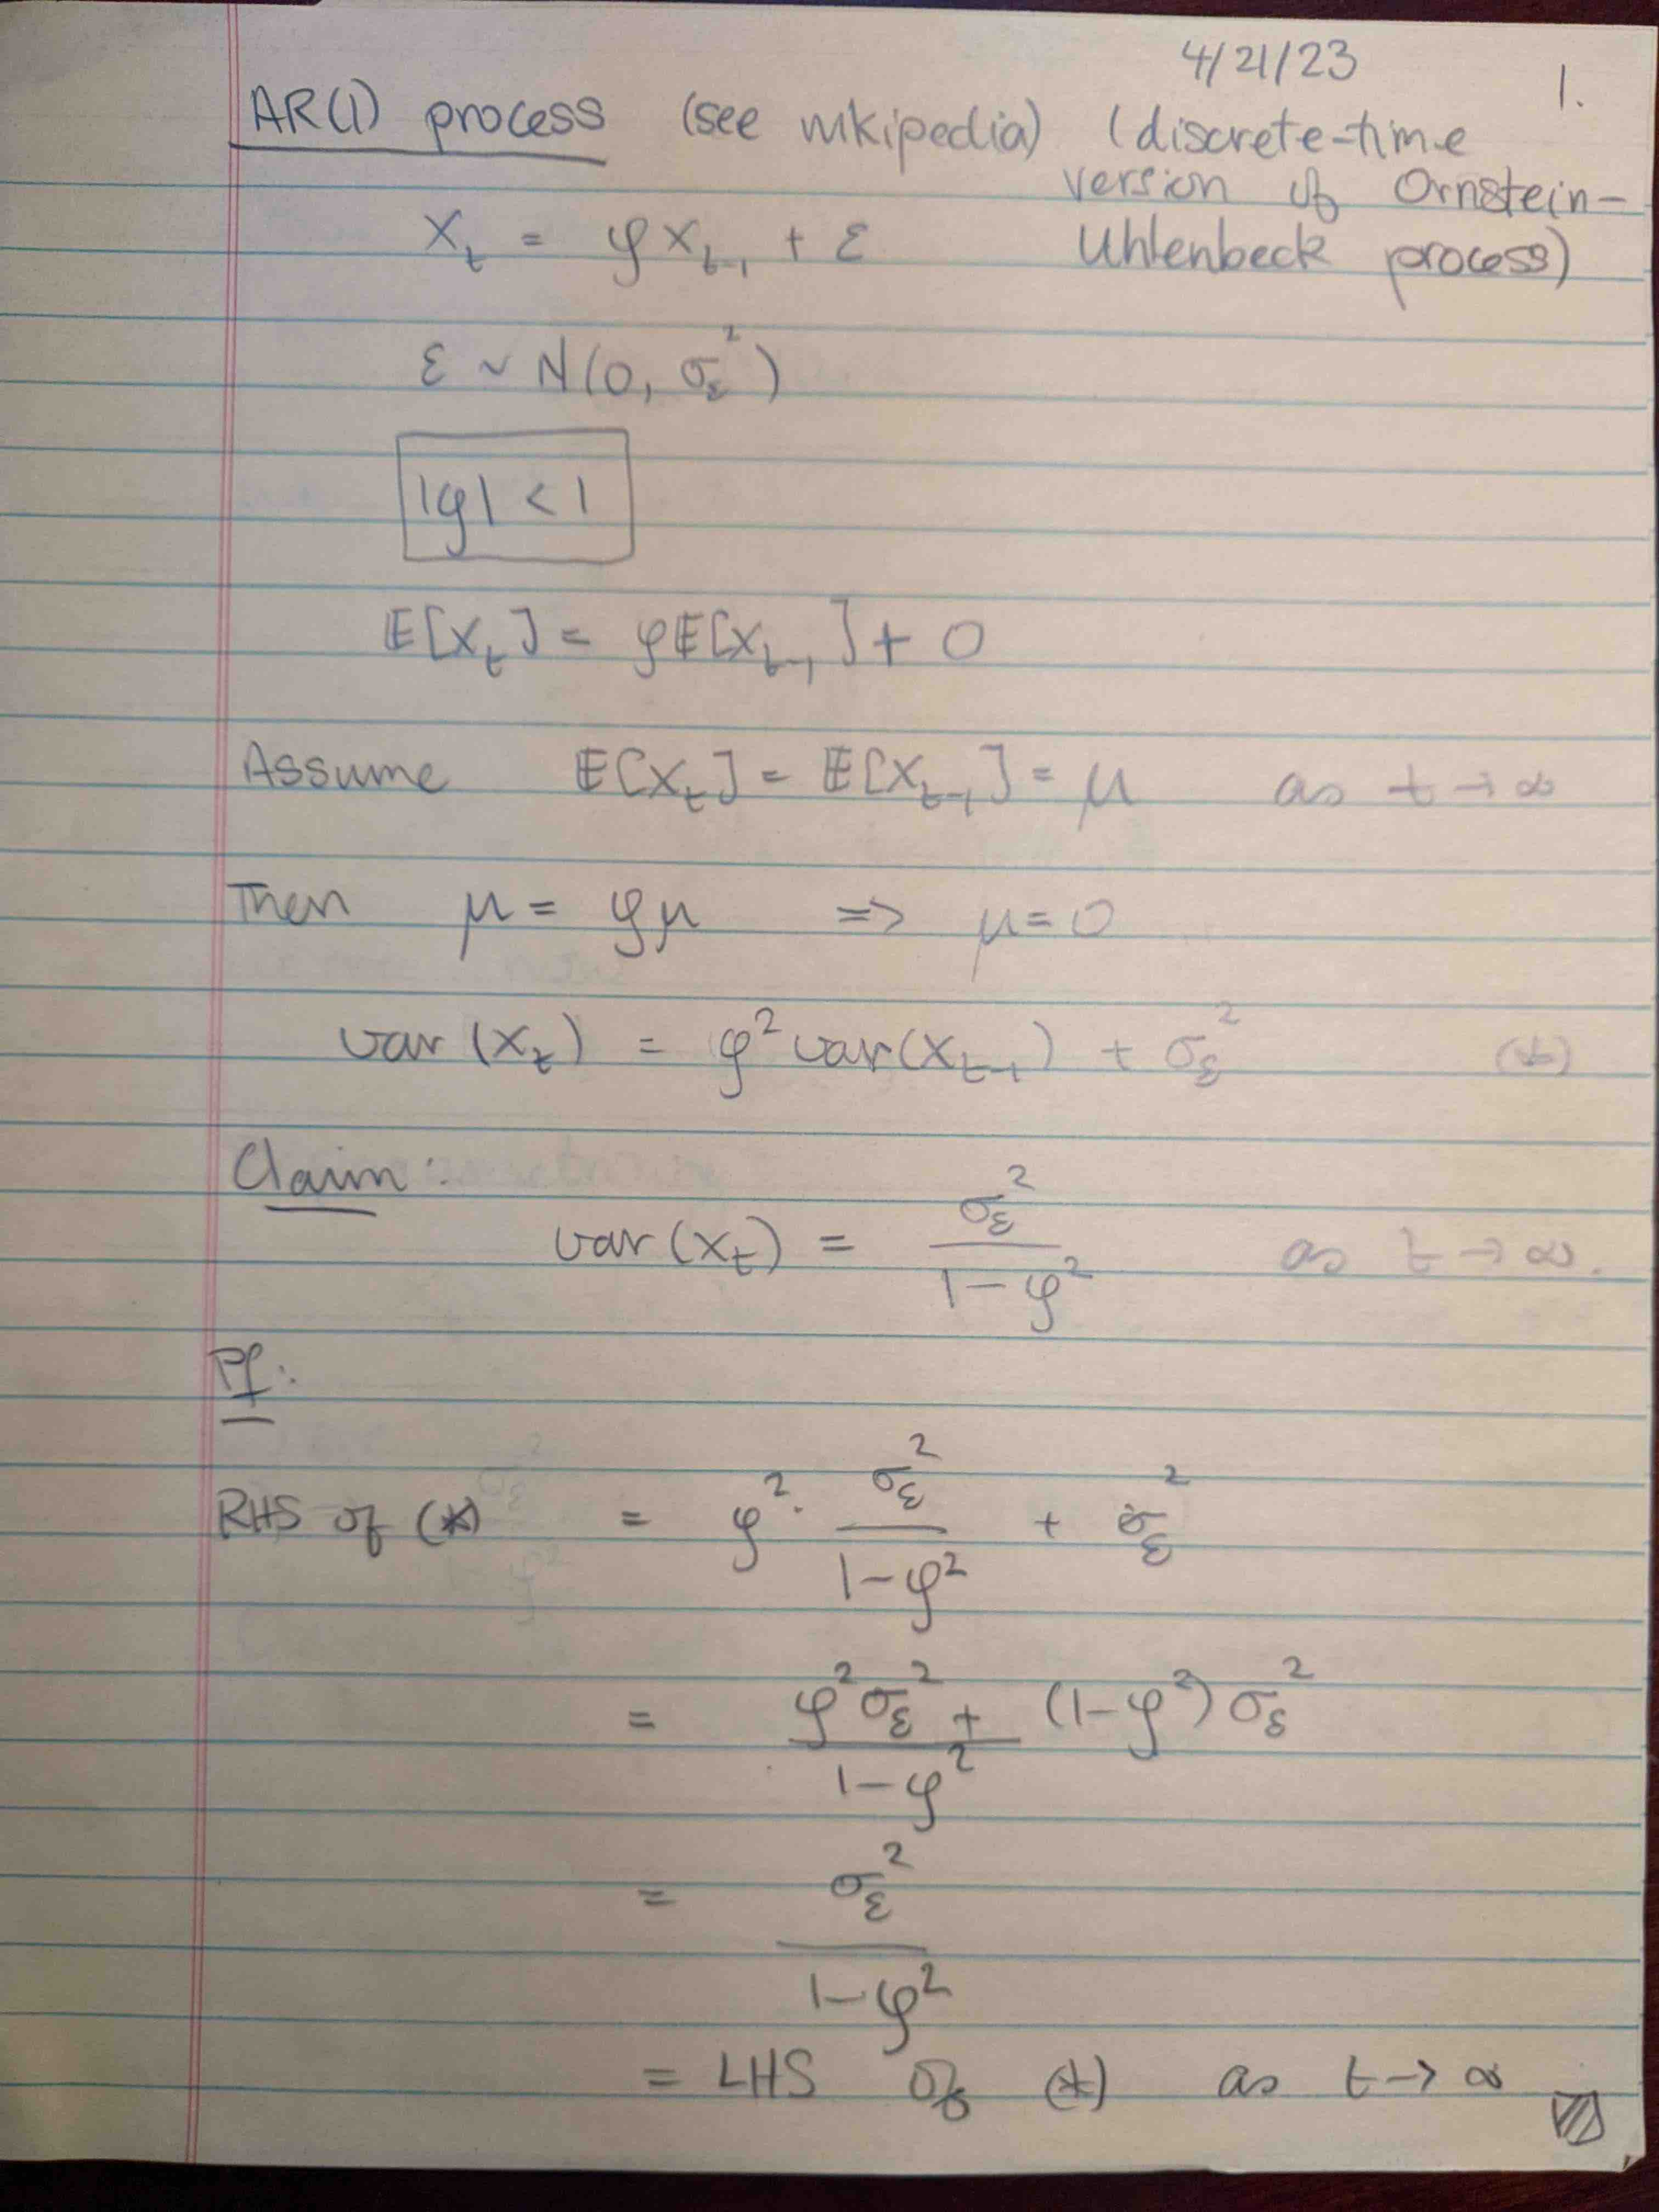

In [1]:
from IPython.display import Image
Image(filename = 'AR(1) p1.jpeg', width=500)

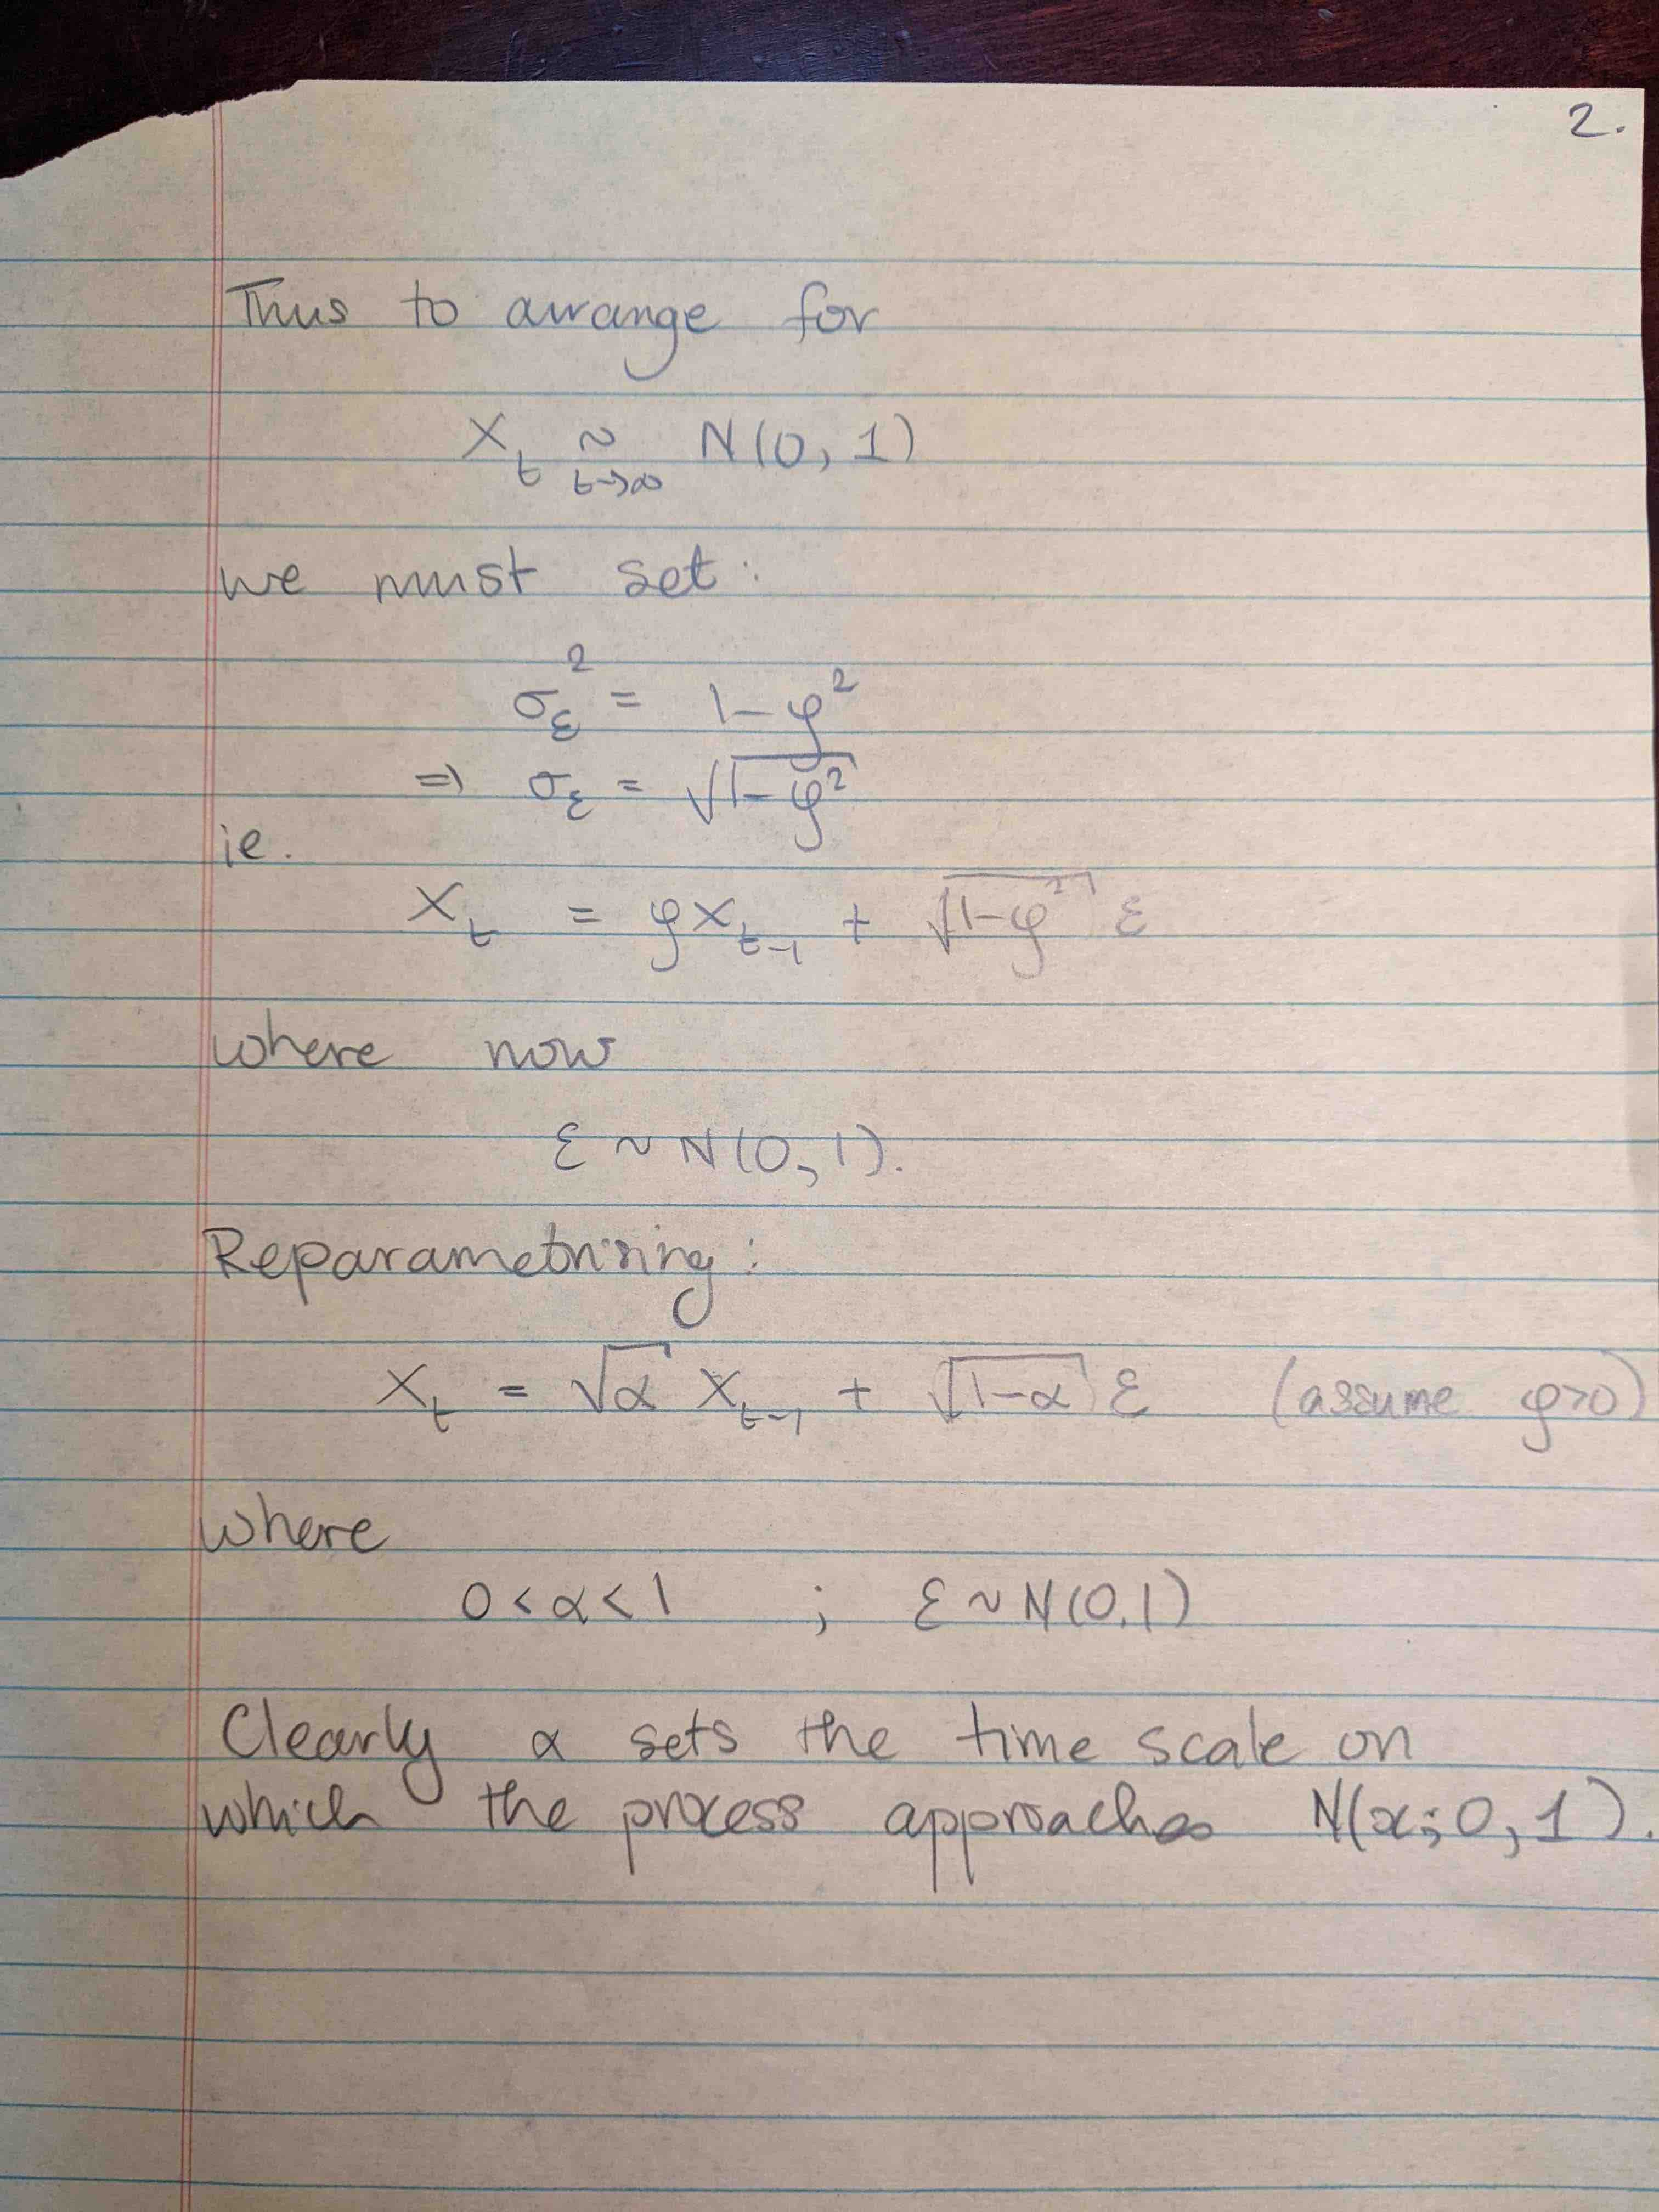

In [3]:
Image(filename = 'AR(1) p2.jpeg', width=500)


Note that $\alpha$ sets the time scale on which the process 
approaches equilibrium, such that smaller $\alpha$ makes the approach faster. 
In Ho et al's model, the $\alpha$ parameter decreases over time, 
such that the early latent encodings are close to the original image, 
but then rapidly approach pure noise (the stationary distribution). 


The AR(1) process is the discrete-time version of the [Ornstein-Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process), 
which has a mean-reverting "drift" term that counteracts the explosion of variance in the process 
that would otherwise occur due to "diffusion". Here I am using the term "drift" in the sense described [here](https://en.wikipedia.org/wiki/Fokker%E2%80%93Planck_equation#One_dimension).

Incidentally, the reverse (decoding) process also has a "drift" term at each time point, as exposed by Luo in his Eq. (158) on p19. That drift turns out to be the log-gradient of the noisy data distribution at that time point, causing the "particle" to drift towards the mode(s) of the noisy data distribution. Though the mode is centered at zero at late times (the stationary distribution of the forward process, by construction), causing the particle to drift towards zero, the noisy data distribution approaches the true data distribution at earlier times (again by construction), so at earlier times the particle shifts its drift towards one of the modes of the true data distribution. 

## How the "reconstruction term" appears in Algorithm 1

By analagy with the $t>1$ cases, the $t=1$ case of the loss specified in Algorithm 1 derives from 

$$ 
- \mathbb{E}_{q(x_1 | x_0)} \left[ D_{KL} \left( q(x_0' | x_1, x_0) \, \lVert \, p_\theta ( x_0' | x_1) \right) \right] ,
$$

showing that $p_\theta (x_0' | x_1)$ learns to approximate the ground-truth posterior $q(x_0' | x_1, x_0)$. 
But, $q(x_0' | x_1, x_0) = \delta_{x_0', x_0}$, by definition. Inserting this expression into the 
definition of the KL divergence above yields: 

$$ 
- \mathbb{E}_{q(x_1 | x_0)} \left[ 
- \sum_{x_0'}  \delta_{x_0', x_0}\log \frac{p_\theta ( x_0' | x_1)}{\delta_{x_0', x_0}}
\right] 
= \mathbb{E}_{q(x_1 | x_0)} \left[ \log p_\theta ( x_0 | x_1) \right]
$$ 

which is just the "reconstruction term" in the ELBO (see Eq. (58) on p10 of Luo's paper). 

A corollary to $q(x_0' | x_1, x_0) = \delta_{x_0', x_0}$ is that $\sigma_q(t=1) = 0$, 
explaining step 3 of Algorithm 2 in Ho et al. 

## Optimizing ELBO is equivalent to optimizing message length under the bits-back coding scheme

Although not necessary to understand Luo's paper, it's nice to record here that the Evidence Lower Bound (ELBO) of the variational autoencoder (which the diffusion model is a generalization of) has a neat information-theoretic interpretation: it is the expected length of a lossless encoding of a typical data point (and it's latent embedding) under the "bits-back" encoding scheme, which is beautifully illustrated by Brian Keng [here](https://bjlkeng.io/posts/lossless-compression-with-latent-variable-models-using-bits-back-coding/). 


